In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import sys
sys.path.append('../../acd/acd')
from os.path import isdir
sys.path.append('../../acd/visualization')
sys.path.append('../../acd/acd/util')
sys.path.append('../../acd/acd/scores')
sys.path.append('../../acd/acd/agglomeration')
import viz_1d as viz
import tiling_1d as tiling
import agg_1d as agg
import cd
import score_funcs
from os.path import join
import os
sys.path.append('../../acd')
sys.path.append('../../acd/dsets/sst')
from dsets.sst import dset
from dsets.sst.model import LSTMSentiment
import torch.optim as O
import torch.nn as nn
# check out how two models differ
import torch.optim as O
import torch.nn as nn

from torchtext import data
from torchtext import datasets

In [2]:

vector_cache = os.path.join(os.getcwd(), '.vector_cache/input_vectors.pt')
word_vectors ='glove.6B.300d'
batch_size=  50


In [3]:
def makedirs(name):
    """helper function for python 2 and 3 to call os.makedirs()
       avoiding an error if the directory to be created already exists"""

    import os, errno

    try:
        os.makedirs(name)
    except OSError as ex:
        if ex.errno == errno.EEXIST and os.path.isdir(name):
            # ignore existing directory
            pass
        else:
            # a different error happened
            raise



In [4]:
sst_pkl = pickle.load(open('../../acd/dsets/sst/sst.pkl', 'rb'))

In [5]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# form class to hold data
class B:
    text = torch.zeros(1).to(device)


In [197]:
import random

random.seed(42)

print(random.sample(range(20),k=10))

st = random.getstate()  # remeber this state 

[3, 0, 8, 7, 16, 2, 11, 1, 10, 17]


In [208]:
a, b = train.split()#(random_state=st)

In [209]:
a[0].text

['of', 'perversity', ',', 'comedy', 'and', 'romance']

In [194]:
len(b)

49397

In [179]:

inputs = data.Field(lower= True)
answers = data.Field(sequential=False, unk_token=None)

train, dev, test = datasets.SST.splits(inputs, answers, fine_grained=False, train_subtrees=True,
                                       filter_pred=lambda ex: ex.label != 'neutral')

inputs.build_vocab(train, dev, test)
if word_vectors:
    if os.path.isfile(vector_cache):
        inputs.vocab.vectors = torch.load(vector_cache)
    else:
        inputs.vocab.load_vectors(word_vectors)
        makedirs(os.path.dirname(vector_cache))
        torch.save(inputs.vocab.vectors,vector_cache)
answers.build_vocab(train)

train_iter, dev_iter, test_iter = data.BucketIterator.splits(
    (train, dev, test), batch_size=batch_size, device=torch.device(0))

TypeError: 'Example' object is not iterable

In [175]:
torch.utils.data.split

AttributeError: module 'torch.utils.data' has no attribute 'split'

In [163]:

model1 = torch.load("../../acd/dsets/sst/model2.pt", map_location=torch.device(0))
# model2 = torch.load(join(model_path, model_list[0]), map_location=torch.device(0))

In [164]:
use_regularized = True
model_path = "../../acd/dsets/sst/results/trial874"
model_list = os.listdir(model_path)
model2 = torch.load(join(model_path, model_list[-2]), map_location=torch.device(0))
(model_list)

['best_snapshottrainboth_devacc_82_devloss_0.5285236239433289__iter_1000_model1.pt',
 'best_snapshottrainboth_devacc_82_devloss_0.5285236239433289__iter_1000_model2.pt',
 'snapshot_acc_97.0000_loss_0.160067_iter_2000_model.pt']

In [165]:
model_list[-2]

'best_snapshottrainboth_devacc_82_devloss_0.5285236239433289__iter_1000_model2.pt'

In [166]:
use_regularized

True

In [12]:
use_regularized = False
model2 = torch.load("../../acd/dsets/sst/model1.pt", map_location=torch.device(0))

# Relation between output and explanation divergence


In [167]:
def kl_divergence(in1, in2):
    a= (in1-in2)
    b = (torch.log(in1) - torch.log(in2))

    return (a*b).sum(dim=1).cpu().detach().numpy()

In [168]:
def softmax(scores):
    return torch.nn.functional.softmax(torch.stack((scores[0].view(-1),scores[1].view(-1)), 1), dim = 1)


In [169]:
criterion = nn.CrossEntropyLoss()

In [170]:
model1.eval()
model2.eval()

LSTMSentiment(
  (embed): Embedding(18844, 300)
  (lstm): LSTM(300, 128)
  (hidden_to_label): Linear(in_features=128, out_features=2, bias=True)
)

In [171]:
(answer1 -answer2).abs().sum()

tensor(37.4849, device='cuda:0')

In [172]:
# Model 2
dev_iter.init_epoch()

# check out how two models differ
len_data = len(dev)
num_batches = 5
len_data = num_batches*batch_size
with torch.no_grad():
    cur_idx = 0
    output_div = np.zeros((len_data))
    expl_div = np.zeros((len_data))
    is_correct = np.zeros((2, len_data))
    num_reps = 10
    expl_penalty =0
    ce_penalty = 0
    for dev_batch_idx, dev_batch in enumerate(train_iter):
        print(dev_batch_idx)
        if dev_batch_idx >=num_batches:
            break
        batch_length, batch_num = dev_batch.text.shape
        answer1, answer2 = model1(dev_batch), model2(dev_batch)

        output_div[cur_idx:cur_idx+batch_num] = kl_divergence(torch.nn.functional.softmax(answer1, dim = 1), torch.nn.functional.softmax(answer2, dim = 1))
        for i in range(num_reps):
            start = np.random.randint(batch_length-1)
            stop = start + np.random.randint(batch_length-start)

            softmax_mod1 =softmax(cd.cd_batch_text(dev_batch, model1, start, stop))
            softmax_mod2 =softmax(cd.cd_batch_text(dev_batch, model2, start, stop))

            expl_div[cur_idx:cur_idx+batch_num] +=   kl_divergence(softmax_mod1, softmax_mod2).reshape(2, dev_batch.text.shape[1]).sum(axis =0)
            
            expl_penalty +=(cd.cd_penalty(dev_batch, model1, model2, start, stop))
            ce_penalty +=criterion(answer1, dev_batch.label).cpu().numpy() 

        is_correct[0, cur_idx:cur_idx+batch_num]=(((torch.max(answer1, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data))).cpu().numpy()
        is_correct[1, cur_idx:cur_idx+batch_num]=(((torch.max(answer2, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data))).cpu().numpy()
        cur_idx+=batch_num
    expl_div /=num_reps
    insecure_idx = np.where(is_correct.mean(axis=0) ==0.5)[0]
    right_secure_idx =np.where(is_correct.mean(axis=0) ==1)[0]
    wrong_secure_idx =np.where(is_correct.mean(axis=0) ==0)[0]
    print("Is regularized", use_regularized)
    print("all, {}".format(expl_div.mean().round(decimals=2)))
    print("right, {}".format(expl_div[right_secure_idx].mean().round(decimals=2)))
    print("wrong, {}".format(expl_div[wrong_secure_idx].mean().round(decimals=2)))
    print("one_right, {}".format(expl_div[insecure_idx].mean().round(decimals=2)))

0
1
2
3
4
5
Is regularized True
all, 0.0
right, 0.0
wrong, 0.0
one_right, nan


/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice.


In [157]:
expl_penalty

tensor(1.8636, device='cuda:0')

In [158]:
ce_penalty

7.105624824762344

In [159]:
output_div -= output_div.mean()
output_div/=output_div.std()
expl_div -=expl_div.mean()
expl_div /=expl_div.std()

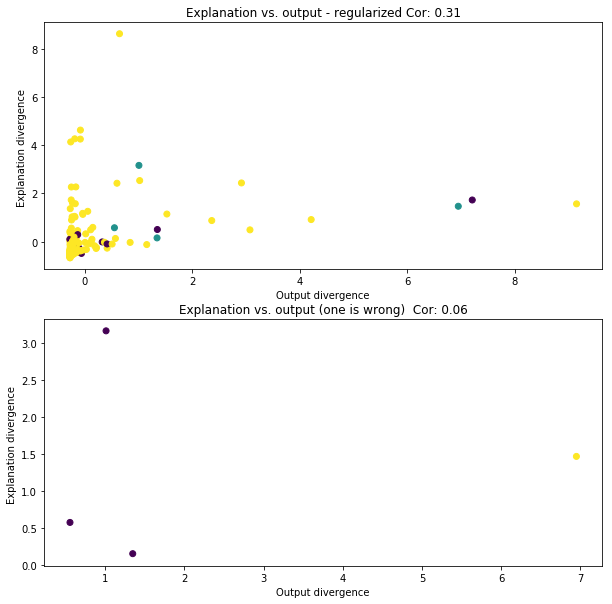

In [160]:


# equivalent but more general
fig = plt.figure(figsize=(10,10))
ax1=plt.subplot(2, 1, 1)

coloring = is_correct.mean(axis=0)
# coloring[np.where(coloring==1)[:10]] =.1
ax1.scatter(output_div, expl_div, c= coloring)
plt.ylabel("Explanation divergence ")
plt.xlabel("Output divergence")
plt.title("Explanation vs. output - regularized Cor: {}".format(np.cov(output_div, expl_div)[0,1].round(decimals=2)));
plt.savefig("Unreg_networks")
# add a subplot with no frame
ax2=plt.subplot(2,1,2)

ax2.scatter(output_div[insecure_idx], expl_div[insecure_idx], c= is_correct[0][insecure_idx])

plt.ylabel("Explanation divergence ")
plt.xlabel("Output divergence")
plt.title("Explanation vs. output (one is wrong)  Cor: {}".format(np.corrcoef(output_div[insecure_idx], expl_div[insecure_idx])[0,1].round(decimals=2)));

In [161]:
print("Correlation")
print("Both right, {}".format(np.corrcoef(output_div[right_secure_idx], expl_div[right_secure_idx])[0,1].round(decimals=2)))
print("one right, {}".format(np.corrcoef(output_div[insecure_idx], expl_div[insecure_idx])[0,1].round(decimals=2)))
print("none right, {}".format(np.corrcoef(output_div[wrong_secure_idx], expl_div[wrong_secure_idx])[0,1].round(decimals=2)))

Correlation
Both right, 0.27
one right, 0.06
none right, 0.92


In [162]:
print("Divergence between")

print("Both right, {}".format(expl_div[right_secure_idx].mean().round(decimals=2)))
print("one right, {}".format(expl_div[insecure_idx].mean().round(decimals=2)))
print("none right, {}".format(expl_div[wrong_secure_idx].mean().round(decimals=2)))


Divergence between
Both right, -0.03
one right, 1.34
none right, 0.07


In [73]:
str("trial"+str(np.random.randint(100)))

62

In [75]:
type(os.path.join("Test", "FF"))

str